# Equations
Here we are solving a set of coupled differential equations gives (from Chapman supplement and Arne notebook)

$$\begin{align}
    i \dot{\zeta}_1&= (p_1 B + q_1 B^2 + q\mu_1(t))\zeta_1+c\left[(\zeta_1^*\zeta_1+\zeta_0^*\zeta_0-\zeta_{-1}^*\zeta_{-1})\zeta_1+\zeta_0\zeta_0\zeta_{-1}^*)\right]\\
    i\dot{\zeta}_0&=(p_0 B + q_0 B^2 + q\mu_0(t))\zeta_0+c\left[(\zeta_1^*\zeta_1 + \zeta_{-1}^*\zeta_{-1})\zeta_0 + 2\zeta_1\zeta_{-1}\zeta_0^*\right]\\
    i \dot{\zeta}_{-1}&= (p_{-1} B + q_{-1} B^2 + q\mu_{-1}(t))\zeta_{-1}+c\left[(\zeta_{-1}^*\zeta_{-1}+\zeta_0^*\zeta_0-\zeta_{1}^*\zeta_{1})\zeta_{-1}+\zeta_0\zeta_0\zeta_{1}^*)\right]\\
\end{align}
$$

# Expectation Values
First we note that 
$$ S_x = \frac{1}{\sqrt{2}}\begin{pmatrix}
0&1&0\\
1&0&1\\
0&1&0\\
\end{pmatrix}
$$
So to calculate its expectation value with a given wavefunction, we have
$$\psi^*S_x \psi =  (\psi_1^*,\psi_0^*,\psi_{-1}^*)\frac{1}{\sqrt{2}}\begin{pmatrix}
0&1&0\\
1&0&1\\
0&1&0\\
\end{pmatrix}
\begin{pmatrix}
\psi_1\\
\psi_0\\
\psi_{-1}
\end{pmatrix} = \frac{(\psi_1^*+\psi_{-1}^*)\psi_0 + \psi_0^*(\psi_{1}+\psi_{-1})}{\sqrt{2}}$$


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import complex_ode
from numpy.lib import scimath
%matplotlib inline

In [45]:
#first define the system dy/dt = f(y,t)
def msqr(x):
    return np.conj(x) * x

def f(t,y,*args):
    """system of ode we want to solve"""
    z1i = y[0]
    z0i = y[1]
    zmi = y[2]
    #now define equations
    f0 = ((p1*B+q1*B**2+qu1)*z1i + c*((msqr(z1i) + msqr(z0i) - msqr(zmi))*z1i + z0i*z0i*np.conj(zmi)))*np.complex(0,-1)
    f1 = ((p0*B+q0*B**2+qu0)*z0i + c*((msqr(z1i) + msqr(zmi))*z0i + 2*z1i*zmi*np.conj(z0i)))*np.complex(0,-1)
    f2 = ((pm1*B+qm1*B**2+qum1)*zmi + c*((msqr(zmi) + msqr(z0i) - msqr(z1i))*zmi + z0i*z0i*np.conj(z1i)))*np.complex(0,-1)
    return [f0,f1,f2]   

In [47]:
class Operator(object):
    """class of operator for 3x3 matrices in this problem"""
    def __init__(self, mat,rep):
        self.rep = rep
        self.mat = mat
        
    def apply(self,ele):
        return np.dot(np.conj(ele), np.dot(self.mat,ele.T)).real

S_x = Operator(np.array([[0,1,0],[1,0,1],[0,1,0]])*1/np.sqrt(2),r'$S_x$')
N_yz = Operator(1j/np.sqrt(2)* np.array([[0,-1,0],[1,0,1],[0,-1,0]]),r'$N_{yz}#')
rho_0 = Operator(np.array([[0,0,0],[0,1,0],[0,0,0]]),r'$\rho_0$')

In [157]:
#define problem parameters
dt = .1e-5
tfinal = .03
#allot arrays
t = np.linspace(0,tfinal,int(tfinal/dt))

def validate(par,t):
    """function to validate arrays"""
    lt = len(t)
    if isinstance(par,float) or isinstance(par,int) or isinstance(par,np.complex):
        return np.asarray([par for i in t])
    elif len(par)==lt:
        return par
    else:
        print('check array dimensions')
        
#define parameters
B =  .21
p1 = 0
p0 = 0
pm1 = 0
qu1 =0
qu0 = 0
qum1= 0
q1 = 0
q0 = -2 *np.pi* 1109 + 2*np.pi* 832
qm1=0
c = 2*np.pi*36

B_arr = validate(B,t)
p1_arr = validate(p1,t)
p0_arr = validate(p0,t)
pm1_arr = validate(pm1,t)
qu1_arr = validate(qu1,t)
qu0_arr = validate(qu0,t)
qum1_arr = validate(qum1,t)
q1_arr = validate(q1,t)
q0_arr = validate(q0,t)
qm1_arr = validate(qm1,t)
c_arr = validate(c,t)

In [158]:
#solve the sucker and plot
def solve_system(y0):
    r = complex_ode(f)
    r.set_initial_value(y0,0)
    ans = np.zeros((len(t),3),dtype = complex)
    step  = 0
    while r.successful() and r.t < tfinal:
        #update the parameters
        B = B_arr[step]
        p1 = p1_arr[step]
        p0 = p0_arr[step]
        pm1 = pm1_arr[step]
        qu1 = qu1_arr[step]
        qu0 = qu0_arr[step]
        qum1 = qum1_arr[step]
        q1 = q1_arr[step]
        q0 = q0_arr[step]
        qm1 = qm1_arr[step]
        c = c_arr[step]
        ans[step] = np.asarray(r.integrate(r.t + dt))
        step += 1
    return ans

def get_exp_values(sol,step_size):
    """function to compute expectation values"""
    r_0 = np.asarray([rho_0.apply(i) for i in sol[::step_size]])
    sx_calc = np.asarray([S_x.apply(i) for i in sol[::step_size]])
    nyz_calc = np.asarray([N_yz.apply(i) for i in sol[::step_size]])
    return np.asarray([r_0, sx_calc, nyz_calc])

In [159]:
step_size = 500
#do calculation
N = 40000
m = 0
theta = 0
rho = (N-1)/N
state = [scimath.sqrt((1-rho+m)/2)*np.exp(theta/2*1j),scimath.sqrt(rho),scimath.sqrt((1-rho-m)/2) * np.exp(theta/2*1j)]
ans = get_exp_values(solve_system(state),step_size)

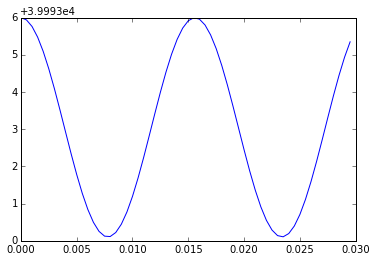

In [160]:
plt.plot(t[::step_size],ans[0]*N)

In [161]:
from lmfit import Model
def sinfunc(x,A,f,off,phi):
    return A * np.sin(2*np.pi*f*x+phi)+off
sinmod = Model(sinfunc)

[[Model]]
    Model(sinfunc)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 60
    # variables        = 4
    chi-square         = 0.000
    reduced chi-square = 0.000
[[Variables]]
    f:     64.1428291 +/- 0.000228 (0.00%) (init= 65)
    A:     2.94695832 +/- 3.54e-05 (0.00%) (init= 6)
    off:   39996.0510 +/- 2.65e-05 (0.00%) (init= 39991)
    phi:   1.57119578 +/- 2.51e-05 (0.00%) (init= 3.141593)
[[Correlations]] (unreported correlations are <  0.100)
    C(f, phi)                    = -0.888 
    C(f, off)                    = -0.387 
    C(off, phi)                  =  0.352 
    C(f, A)                      = -0.136 
    C(A, phi)                    =  0.132 
    C(A, off)                    =  0.101 


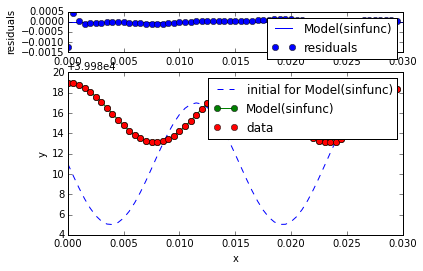

In [162]:
pars = sinmod.make_params(A = 6,f = 65, off = 39991,phi=np.pi)
pars['phi'].min = 0
pars['phi'].max = 2*np.pi
pars['A'].min = 0
fit = sinmod.fit(x = t[::step_size],data = ans[0]*N,params = pars)
fit.plot(fitfmt='-o');
print(fit.fit_report())
#help(fit)

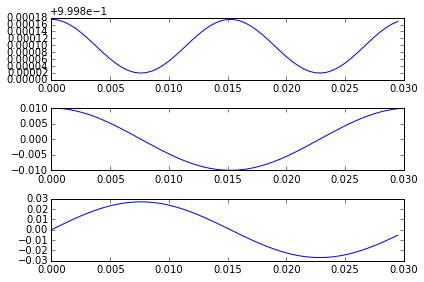

In [156]:
fig, ax = plt.subplots(3,1)
for i in range(3):
    m = ans[i]
    s = ans[i]
    ax[i].plot(t[::step_size],m)
    #ax[i].fill_between(t[::step_size,],m-s,m+s,facecolor='green',alpha=0.3)
plt.tight_layout()